<a href="https://colab.research.google.com/github/rtajeong/M4/blob/main/lab_07_keras_examples_iris_kfold_callback_rev1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# More on Keras
- from "모두의 딥러닝"

# 12. Multinomial classification
- iris data
- one-hot encoding
- softmax
- F-fold cross validation

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [19]:
np.random.seed(17)
iris_data = sns.load_dataset("iris")
iris_data.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [20]:
dataset = iris_data.values
X = dataset[:,0:4].astype('float')
Y_obj = dataset[:,4]

Y = LabelEncoder().fit_transform(Y_obj)
Y_encoded = utils.to_categorical(Y)   #  one-hot encoding

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encoded, test_size=0.2)

In [21]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((120, 4), (120, 3), (30, 4), (30, 3))

In [22]:
# model and compile & train & predict(evaluate)
model = Sequential()
# model.add(Dense(16,  input_dim=4, activation='relu'))
model.add(Dense(16,  input_shape=(4,), activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                80        
                                                                 
 dense_13 (Dense)            (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=100, 
                    batch_size=20, verbose=0)
model.save('iris_model.h5')     # or model.save('iris_model_dir')

In [24]:
from keras.models import load_model
del model   # delete existing models in memory
model = load_model('iris_model.h5')  # newly call the model
print("\n Accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

1/1 [==============================] - 0s 160ms/step - loss: 0.4862 - accuracy: 0.8667

 Accuracy: 0.8667


In [25]:
X.shape, Y.shape

((150, 4), (150,))

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

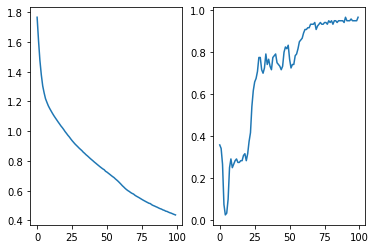

In [27]:
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])

In [28]:
model.evaluate(X_test, Y_test)

1/1 [==============================] - 0s 28ms/step - loss: 0.4862 - accuracy: 0.8667


[0.4861551821231842, 0.8666666746139526]

In [29]:
Y_pred = model.predict(X_test)
tf.math.confusion_matrix(Y_test.argmax(1), Y_pred.argmax(1))

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 7,  0,  0],
       [ 0,  8,  3],
       [ 0,  1, 11]], dtype=int32)>

# K-fold validation

In [30]:
X.shape, Y.shape

((150, 4), (150,))

In [31]:
from sklearn.model_selection import StratifiedKFold

n_fold = 5
skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=17)

cvscores = []
for train_index, test_index in skf.split(X, Y):
    model = Sequential()
    model.add(Dense(16,  input_shape=(4,), activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    y_train_enc = utils.to_categorical(y_train)
    y_test_enc = utils.to_categorical(y_test)
    
    model.fit(X_train, y_train_enc, epochs=30, batch_size=5, verbose=0)
    score = model.evaluate(X_test, y_test_enc, verbose=0)
    cvscores.append(score)

In [32]:
model.metrics_names, cvscores, np.mean(cvscores, axis=0)

(['loss', 'accuracy'],
 [[0.3532349169254303, 0.9666666388511658],
  [0.37776872515678406, 0.8999999761581421],
  [0.3750266432762146, 0.9666666388511658],
  [0.44036927819252014, 0.9666666388511658],
  [0.34453946352005005, 0.9666666388511658]],
 array([0.37818781, 0.95333331]))

# 14. Callback - check point and early stopping
- Callback 함수: 명시적으로 호출되는 게 아니라 나중에 어떤 event 가 발생했을 때 호출되는 함수

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import pandas as pd
import numpy as np
import os
import tensorflow as tf

- download wine.csv from https://codedragon.tistory.com/9480
  - class 1: red wine, 0: white wine

In [34]:
df_all = pd.read_csv('wine.csv', header=None)
df = df_all.sample(frac=0.2)  # get only 20% of dataset
df.shape

(1299, 13)

In [35]:
df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12
3896,6.5,0.29,0.42,10.6,0.042,66.0,202.0,0.99674,3.24,0.53,9.5,6,0


In [36]:
df[12].value_counts()

0    984
1    315
Name: 12, dtype: int64

In [37]:
dataset = df.values
X, y = dataset[:,0:12], dataset[:,12]

model = Sequential()
model.add(Dense(30,  input_dim=12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])

# 모델 저장 폴더 만들기
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"

# 모델 업데이트 및 저장 (epoch 마다)
checkpointer = ModelCheckpoint(filepath=modelpath, 
                               monitor='val_loss', 
                               verbose=1, 
                               save_best_only=True)  # record only when imrpoved

# 테스트 오차가 줄지 않으면 학습 자동 중단 설정 (모니터할 값 저장)
early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=100) # 좋아지지 않아도 몇 번까지 기다릴것인지


Epoch 00001: val_loss improved from inf to 1.39656, saving model to ./model/01-1.3966.hdf5

Epoch 00002: val_loss improved from 1.39656 to 0.50489, saving model to ./model/02-0.5049.hdf5

Epoch 00003: val_loss improved from 0.50489 to 0.25595, saving model to ./model/03-0.2559.hdf5

Epoch 00004: val_loss improved from 0.25595 to 0.21003, saving model to ./model/04-0.2100.hdf5

Epoch 00005: val_loss improved from 0.21003 to 0.20488, saving model to ./model/05-0.2049.hdf5

Epoch 00006: val_loss improved from 0.20488 to 0.19912, saving model to ./model/06-0.1991.hdf5

Epoch 00007: val_loss improved from 0.19912 to 0.19408, saving model to ./model/07-0.1941.hdf5

Epoch 00008: val_loss improved from 0.19408 to 0.19008, saving model to ./model/08-0.1901.hdf5

Epoch 00009: val_loss improved from 0.19008 to 0.18957, saving model to ./model/09-0.1896.hdf5

Epoch 00010: val_loss improved from 0.18957 to 0.18719, saving model to ./model/10-0.1872.hdf5

Epoch 00011: val_loss improved from 0.18719

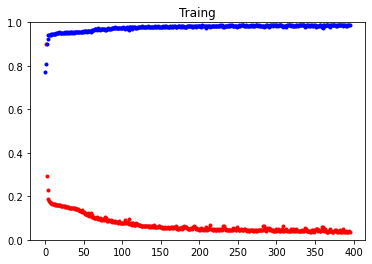

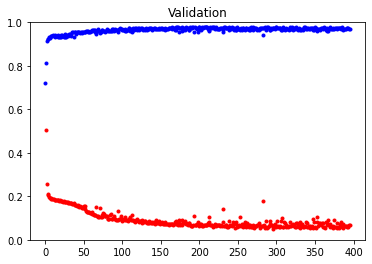

In [38]:
y_loss, y_acc, y_vloss, y_vacc = [], [], [], []

history = model.fit(X, y, validation_split=0.2, 
                    epochs=2000, batch_size=100, verbose=0, 
                    callbacks=[early_stopping_callback,checkpointer])
y_loss = history.history['loss']
y_acc = history.history['accuracy']
y_vloss = history.history['val_loss']
y_vacc = history.history['val_accuracy']
x_len = np.arange(len(y_acc))
plt.ylim(0.,1.)
plt.title("Traing")
plt.plot(x_len, y_loss, "o", c="r", markersize=3)
plt.plot(x_len, y_acc, "o", c="b", markersize=3)
plt.show()
plt.title("Validation")
plt.ylim(0.,1.)
plt.plot(x_len, y_vloss, "o", c="r", markersize=3)
plt.plot(x_len, y_vacc, "o", c="b", markersize=3)
plt.show()

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [40]:
print("Acuracy: %.4f" %(model.evaluate(X, y)[1]))

41/41 [==============================] - 0s 3ms/step - loss: 0.0421 - accuracy: 0.9823
Acuracy: 0.9823


- 2000 epoch 전에 중간에 중단됨을 알 수 있다.

# Regression - boston house price
- boston area house price estimates

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split

import numpy
import pandas as pd
import tensorflow as tf

In [42]:
from sklearn.datasets import load_boston
house = load_boston()
X, y = house.data, house.target

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [43]:
X.shape, y.shape

((506, 13), (506,))

In [44]:
[i for i in dir(house) if not i.startswith("_")]

['DESCR', 'data', 'data_module', 'feature_names', 'filename', 'target']

In [45]:
house.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [46]:
X[:5], y[:5]

(array([[6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01,
         6.5750e+00, 6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02,
         1.5300e+01, 3.9690e+02, 4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
         6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
         1.7800e+01, 3.9690e+02, 9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
         7.1850e+00, 6.1100e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
         1.7800e+01, 3.9283e+02, 4.0300e+00],
        [3.2370e-02, 0.0000e+00, 2.1800e+00, 0.0000e+00, 4.5800e-01,
         6.9980e+00, 4.5800e+01, 6.0622e+00, 3.0000e+00, 2.2200e+02,
         1.8700e+01, 3.9463e+02, 2.9400e+00],
        [6.9050e-02, 0.0000e+00, 2.1800e+00, 0.0000e+00, 4.5800e-01,
         7.1470e+00, 5.4200e+01, 6.0622e+00, 3.0000e+00, 2.2200e+02,
         1.8700e+01, 3.9690e+02, 5.3300e+00]]),
 array([24. , 21.6, 34.7, 33.4, 36.2]))

In [47]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = Sequential()
model.add(Dense(30, input_dim=13, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='linear'))    # no need of activation function
model.summary()
model.compile(loss='mse',
              optimizer='adam')

history = model.fit(X_train, y_train, epochs=200, batch_size=10, verbose=0)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 30)                420       
                                                                 
 dense_29 (Dense)            (None, 6)                 186       
                                                                 
 dense_30 (Dense)            (None, 1)                 7         
                                                                 
Total params: 613
Trainable params: 613
Non-trainable params: 0
_________________________________________________________________


In [49]:
history.history.keys()

dict_keys(['loss'])

In [50]:
model.predict(X_test)[:5], model.predict(X_test)[:5].flatten()

(array([[18.645428],
        [30.84918 ],
        [21.323627],
        [ 9.584489],
        [21.260283]], dtype=float32),
 array([18.645428, 30.84918 , 21.323627,  9.584489, 21.260283],
       dtype=float32))

In [51]:
# just for checking
model.predict(X_test)[:5][:,0] == model.predict(X_test)[:5].flatten()

array([ True,  True,  True,  True,  True])

In [52]:
# 예측 값과 실제 값의 비교
y_pred = model.predict(X_test).flatten()
for i in range(10):
    label = y_test[i]
    prediction = y_pred[i]
    print("real price: {:.3f}, predicted price: {:.3f}".format(label, prediction))

real price: 21.000, predicted price: 18.645
real price: 50.000, predicted price: 30.849
real price: 24.300, predicted price: 21.324
real price: 10.400, predicted price: 9.584
real price: 24.400, predicted price: 21.260
real price: 25.000, predicted price: 33.794
real price: 22.500, predicted price: 24.902
real price: 34.700, predicted price: 31.782
real price: 14.000, predicted price: 14.256
real price: 20.300, predicted price: 19.938


In [53]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 4ms/step - loss: 16.4762


16.47616958618164

In [54]:
from sklearn.metrics import r2_score
print(r2_score(y_test, model.predict(X_test)))
print(tf.metrics.mean_squared_error(y_test, model.predict(X_test))[0])

0.8219065185825465
tf.Tensor(112.87058, shape=(), dtype=float32)


In [55]:
y_test.shape, model.predict(X_test).shape

((152,), (152, 1))

# Exercise (연습)
- tf.function: 
  - 내부에서 tf 1.x 처럼 graph 와 execution 이 분리되어 실행됨.
  - 그래프에 작은 연산이 많을 때 eager execution 모드 보다 빠르다고 알려져 있지만 (합성곱처럼) 계산량이 많은 연산 몇 개로 이루어진 그래프는 속도 향상이 없어 보임.
  - 디버깅이 어려워 모든 함수 동작이 확인된 후 붙이는 게 좋음.

In [56]:
# tf.function: Compiles a function into a callable TensorFlow graph.
#               (must be faster), but not always...?
import timeit
@tf.function
def dense_layer1(x, w, b):
    return tf.add(tf.matmul(x, w), b)

%time dense_layer1(tf.ones([3, 2]), tf.ones([2, 2]), tf.ones([2]))

CPU times: user 57.9 ms, sys: 2.86 ms, total: 60.8 ms
Wall time: 60.6 ms


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[3., 3.],
       [3., 3.],
       [3., 3.]], dtype=float32)>

In [57]:
def dense_layer2(x, w, b):
    return tf.add(tf.matmul(x, w), b)
    
%time dense_layer2(tf.ones([3, 2]), tf.ones([2, 2]), tf.ones([2]))

CPU times: user 2.62 ms, sys: 0 ns, total: 2.62 ms
Wall time: 2.38 ms


<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[3., 3.],
       [3., 3.],
       [3., 3.]], dtype=float32)>

In [58]:
import timeit
conv_layer = tf.keras.layers.Conv2D(100, 3)

@tf.function
def conv_fn(image):
  return conv_layer(image)

image = tf.zeros([1, 200, 200, 100])
# 워밍 업
conv_layer(image); conv_fn(image)
print("Eager execution convolution:", timeit.timeit(lambda: conv_layer(image), number=10))
print("tf.function convolution:", timeit.timeit(lambda: conv_fn(image), number=10))
print("no difference between these two to execute convolution !")

Eager execution convolution: 0.006540416999996523
tf.function convolution: 0.0077386810000348305
no difference between these two to execute convolution !
